## **Predictive Customer Churn Analysis in Telecommunications using Apache Spark**

In [ ]:
# Install required libraries
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=d1bf70aad9f1a691e4aba8dc1f59426415313c6ca52bf58fb9476540d670497b
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
#Import Libraries
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import when, col

In [ ]:
# Create a Spark session
spark = SparkSession.builder.appName("AdvancedChurnAnalysis").getOrCreate()

In [ ]:
# Assuming you have uploaded the CSV file to your Colab environment
from google.colab import files

# Upload the CSV file
uploaded = files.upload()

# Get the filename
filename = list(uploaded.keys())[0]

# Load the dataset
data = spark.read.csv(filename, header=True, inferSchema=True)

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv


### **Data Cleaning and Preprocessing**

In [ ]:
data.show(10)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [ ]:
data.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [ ]:
print("Summary Statistics:")
data.describe().show()

Summary Statistics:
+-------+----------+------+------------------+-------+----------+------------------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+------------------+-----+
|summary|customerID|gender|     SeniorCitizen|Partner|Dependents|            tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|    MonthlyCharges|      TotalCharges|Churn|
+-------+----------+------+------------------+-------+----------+------------------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+------------------+-----+
|  count|      7043|  7043|              7043|   7

In [ ]:
# Convert 'Churn' column to numerical values (0 or 1)
data = data.withColumn("Churn", when(data["Churn"] == "Yes", 1).otherwise(0))

In [ ]:
# Handle null values in the dataset by replacing them with zeros
data = data.na.fill(0)

### **Feature Engineering**

In [ ]:
# Convert categorical features to numerical using StringIndexer
categorical_columns = ["gender", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod"]

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(data) for column in categorical_columns]
for indexer in indexers:
    data = indexer.transform(data)

In [ ]:
# Convert 'TotalCharges' column to numerical type
data = data.withColumn("TotalCharges", col("TotalCharges").cast("double"))

In [ ]:
# Assemble features into a vector
feature_cols = ["SeniorCitizen", "Partner_index", "Dependents_index", "tenure", "PhoneService_index", "MultipleLines_index", "InternetService_index", "OnlineSecurity_index", "OnlineBackup_index", "DeviceProtection_index", "TechSupport_index", "StreamingTV_index", "StreamingMovies_index", "Contract_index", "PaperlessBilling_index", "PaymentMethod_index", "MonthlyCharges"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(data).select("features", "Churn")

### **Model Training**

In [ ]:
# Split the data into training and testing sets
(train_data, test_data) = data.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Create a RandomForestClassifier
rf = RandomForestClassifier(labelCol="Churn", featuresCol="features")

In [ ]:
# Build a parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

In [ ]:
# Create an evaluator
evaluator = BinaryClassificationEvaluator(labelCol="Churn")

In [ ]:
# Create a cross-validator
cv = CrossValidator(estimator=rf, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)

In [ ]:
# Create an ML pipeline
pipeline = Pipeline(stages=indexers + [assembler, rf])

In [ ]:
# Fit the model
cv_model = cv.fit(train_data)

In [ ]:
# Make predictions on the test set
predictions = cv_model.transform(test_data)

### **Model Evaluation**

In [ ]:
# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="Churn")
area_under_curve = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print(f"Best model's parameters: {cv_model.bestModel.extractParamMap()}")
print(f"Area under ROC curve: {area_under_curve}")

Best model's parameters: {Param(parent='RandomForestClassifier_065bd44911ec', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True, Param(parent='RandomForestClassifier_065bd44911ec', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='RandomForestClassifier_065bd44911ec', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='RandomForestClassifier_065bd44911ec', name='featureSubsetStrategy', doc="The number of features to consider for splits a

In [ ]:
# Display feature importances
best_model = cv_model.bestModel
feature_importances = best_model.featureImportances

print("Feature Importances:")
for i, importance in enumerate(feature_importances):
    print(f"{feature_cols[i]}: {importance}")


Feature Importances:
SeniorCitizen: 0.004105565254818788
Partner_index: 0.0008966777256239576
Dependents_index: 0.001310859388086209
tenure: 0.2156269690513796
PhoneService_index: 0.0018717598807037796
MultipleLines_index: 0.0018861954633522184
InternetService_index: 0.11228859558643067
OnlineSecurity_index: 0.10872583932768573
OnlineBackup_index: 0.023880707438044248
DeviceProtection_index: 0.009981962098423025
TechSupport_index: 0.14938667467008052
StreamingTV_index: 0.002425236439911351
StreamingMovies_index: 0.00984365473271946
Contract_index: 0.27158953965076005
PaperlessBilling_index: 0.00482481209864776
PaymentMethod_index: 0.06155387103662671
MonthlyCharges: 0.019801080156705973


In [ ]:
# Show some sample predictions
print("Sample Predictions:")
predictions.select("Churn", "prediction", "probability").show(10)

Sample Predictions:
+-----+----------+--------------------+
|Churn|prediction|         probability|
+-----+----------+--------------------+
|    0|       0.0|[0.61625787296122...|
|    0|       0.0|[0.66859448799186...|
|    0|       0.0|[0.56770400213151...|
|    0|       0.0|[0.58009962008060...|
|    0|       0.0|[0.62594049944370...|
|    0|       0.0|[0.62303213223820...|
|    0|       0.0|[0.73563594750378...|
|    1|       0.0|[0.68509451201665...|
|    0|       0.0|[0.69502535698571...|
|    1|       0.0|[0.50746095865050...|
+-----+----------+--------------------+
only showing top 10 rows



### **Results-Model Performance Evaluation**

In [ ]:
# Count the number of predicted churn cases
predicted_churn_count = predictions.filter(predictions['prediction'] == 1.0).count()

# Total number of records
total_records = predictions.count()

# Percentage of customers predicted to churn
percentage_churn = (predicted_churn_count / total_records) * 100

print(f"Out of {total_records} records, {predicted_churn_count} are predicted to churn.")
print(f"This represents {percentage_churn:.2f}% of the customers.")


Out of 1345 records, 222 are predicted to churn.
This represents 16.51% of the customers.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.ml import PipelineModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [ ]:
# Convert labels and predictions to double
prediction_and_labels = predictions.select(['prediction', 'Churn']).rdd.map(lambda row: (float(row['prediction']), float(row['Churn'])))

# Create MulticlassMetrics object
multiclass_metrics = MulticlassMetrics(prediction_and_labels)

# Confusion Matrix
print("Confusion Matrix:")
print(multiclass_metrics.confusionMatrix().toArray())


Confusion Matrix:
[[909.  66.]
 [214. 156.]]


In [ ]:
# Overall statistics
print("Accuracy:", multiclass_metrics.accuracy)
print("Precision:", multiclass_metrics.precision(1.0))
print("Recall:", multiclass_metrics.recall(1.0))
print("F1 Score:", multiclass_metrics.fMeasure(1.0))

Accuracy: 0.79182156133829
Precision: 0.7027027027027027
Recall: 0.42162162162162165
F1 Score: 0.5270270270270271


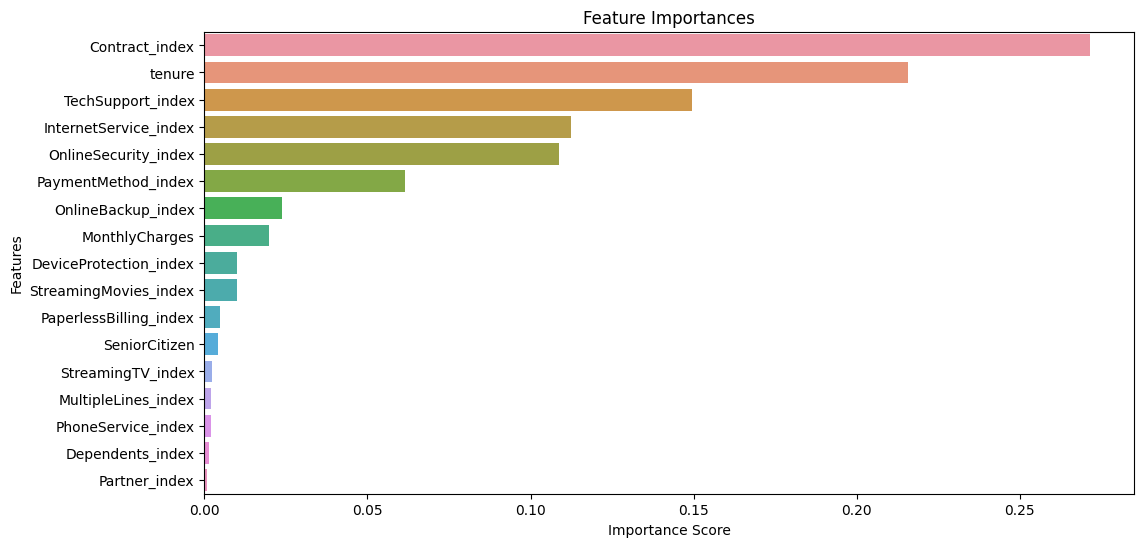

In [ ]:
# Convert feature importances to a Pandas DataFrame
importance_df = pd.DataFrame({"Feature": feature_cols, "Importance": feature_importances.toArray()})

# Plotting feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df.sort_values(by="Importance", ascending=False))
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

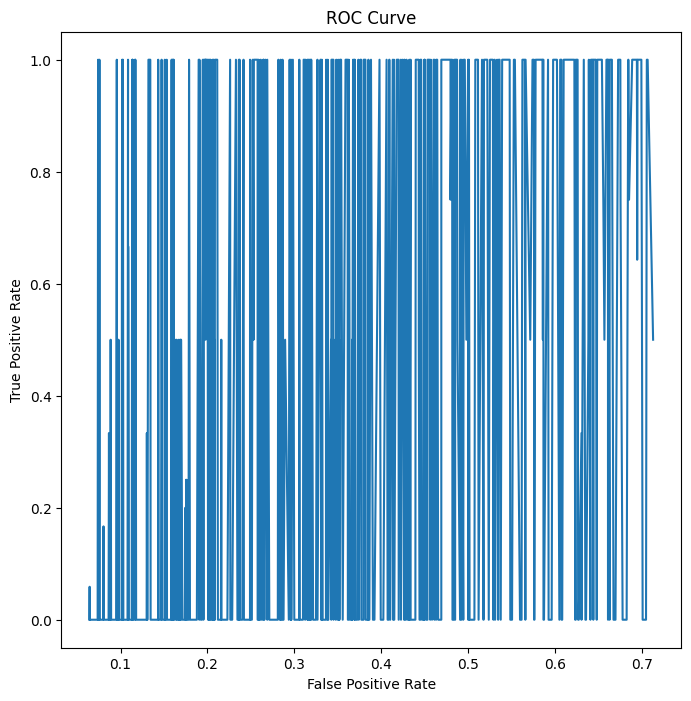

In [ ]:
# Plot ROC curve
roc_curve = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
roc = predictions.select("Churn", "probability").rdd.map(lambda row: (float(row['probability'][1]), float(row['Churn'])))
roc_df = spark.createDataFrame(roc, ["probability", "Churn"])

plt.figure(figsize=(8, 8))
sns.lineplot(x='probability', y='Churn', data=roc_df.toPandas(), err_style=None)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()